In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
import glob
import missingno as msno
from fbprophet import Prophet
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
from datetime import datetime, timedelta

In [2]:
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

## Read all files from multiple monitoring sites into one file

In [3]:
path =r'../input/beijing-multisite-airquality-data-set/' 
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
# read all files from different monitoring sites
for file_ in allFiles:
    dataFrame = pd.read_csv(file_,index_col=None, header=0)
    list_.append(dataFrame)
df = pd.concat(list_)
# add columns to the data frame
cols = ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP',
       'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station']
df = df[cols]
# sort the df with station names and year, so the earliest data can appear first
df = df.sort_values(['station', 'year'])
df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [4]:
df.describe()
df_for_normalization = df

## Imputing Missing Values

In [5]:
df = df.dropna()
df

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [6]:
# verify no missing values in the data frame after imputation
round(df.isnull().sum()/len(df.index), 2)*100

No         0.0
year       0.0
month      0.0
day        0.0
hour       0.0
PM2.5      0.0
PM10       0.0
SO2        0.0
NO2        0.0
CO         0.0
O3         0.0
TEMP       0.0
PRES       0.0
DEWP       0.0
RAIN       0.0
wd         0.0
WSPM       0.0
station    0.0
dtype: float64

## Display SO2 by year 

<AxesSubplot:xlabel='year', ylabel='SO2'>

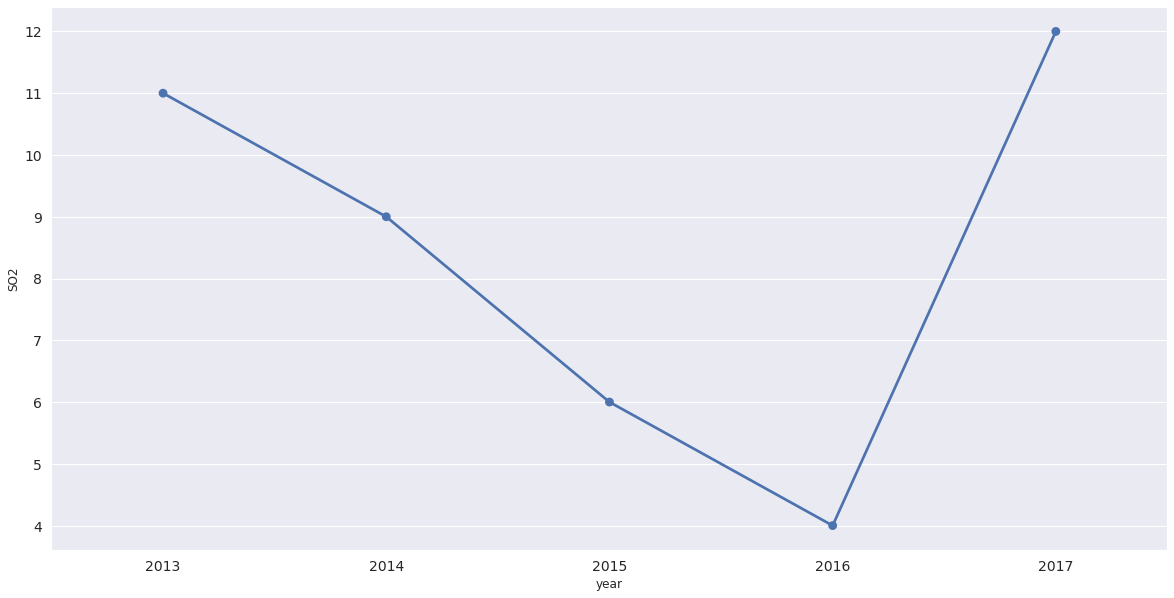

In [7]:
data = df[['SO2','year','station']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
sns.pointplot(x='year', y='SO2', data=data)

## Display NO2 by year

<AxesSubplot:xlabel='year', ylabel='NO2'>

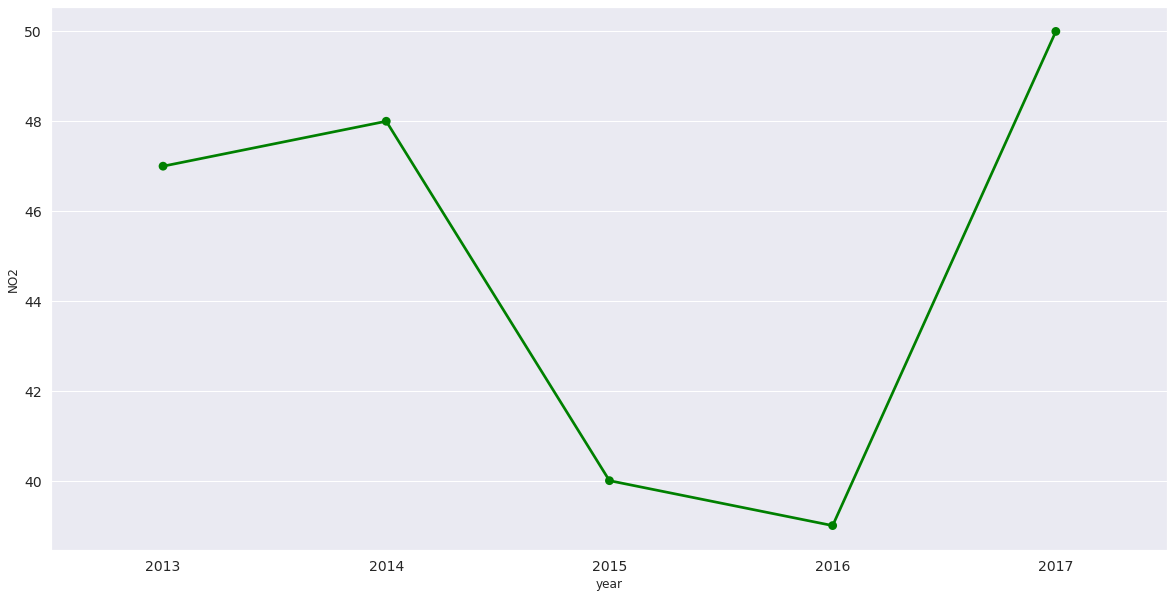

In [8]:
data = df[['NO2','year','station']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
sns.pointplot(x='year', y='NO2', color='green', data=data)

## Display PM2.5 by year

<AxesSubplot:xlabel='year', ylabel='PM2.5'>

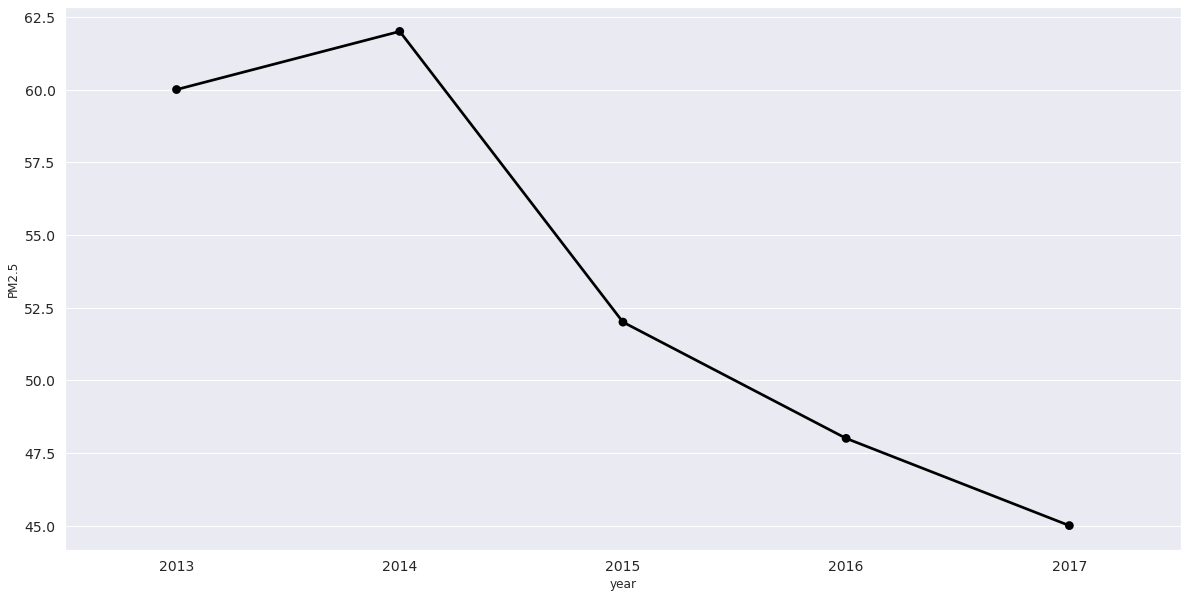

In [9]:
data = df[['PM2.5','year','station']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
sns.pointplot(x='year', y='PM2.5', color = 'black', data=data)

## Display PM10 by year

<AxesSubplot:xlabel='year', ylabel='PM10'>

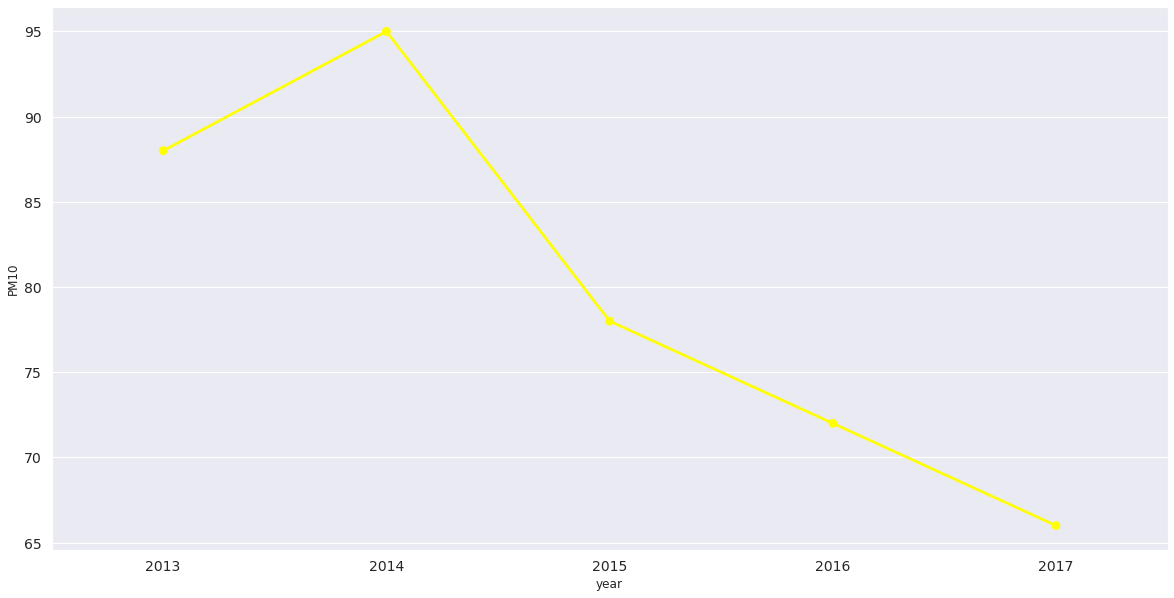

In [10]:
data = df[['PM10','year','station']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
sns.pointplot(x='year', y='PM10', color = 'yellow',data=data)

## Comparator used to sort data by hour

In [11]:
new_df = df
rnn_df = new_df
def helper(x):
    year = x['year']
    month = x['month']
    day = x['day']
    hour = x['hour']
    
    if(month >= 10 and day >= 10 and hour >= 10):
        return ','.join(x.astype(str))
    tmp = year.astype(str)
    tmp = tmp + ',' + month.astype(str) if month >= 10 else tmp + ',0' + month.astype(str)
    tmp = tmp + ',' + day.astype(str) if day >= 10 else tmp + ',0' + day.astype(str)
    tmp = tmp + ',' + hour.astype(str) if hour >= 10 else tmp + ',0' + hour.astype(str)
    return tmp

rnn_df['time'] = rnn_df[rnn_df.columns[1:5]].apply(
    lambda x: helper(x),
    axis=1
)
rnn_df = rnn_df.drop(columns=['year', 'month','day','hour','station','wd','WSPM'])

rnn_df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,time
0,1,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,"2013,03,01,00"
1,2,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,"2013,03,01,01"
2,3,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,"2013,03,01,02"
3,4,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,"2013,03,01,03"
4,5,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,"2013,03,01,04"


In [12]:
new_df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
time        object
dtype: object

In [13]:
# creating date field for further analysis by extracting day of the week, month etc.
new_df['date']=pd.to_datetime(new_df[['year', 'month', 'day']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# function to find day of the week based on the date field
import calendar
def findDay(date): 
    dayname = calendar.day_name[date.weekday()]
    return dayname

In [15]:
new_df['day_week'] = new_df['date'].apply(lambda x: findDay(x))
new_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,time,date,day_week
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,"2013,03,01,00",2013-03-01,Friday
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,"2013,03,01,01",2013-03-01,Friday
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,"2013,03,01,02",2013-03-01,Friday
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,"2013,03,01,03",2013-03-01,Friday
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,"2013,03,01,04",2013-03-01,Friday


## Analysis of Pollutants in day of the week

<AxesSubplot:xlabel='day_week', ylabel='PM2.5'>

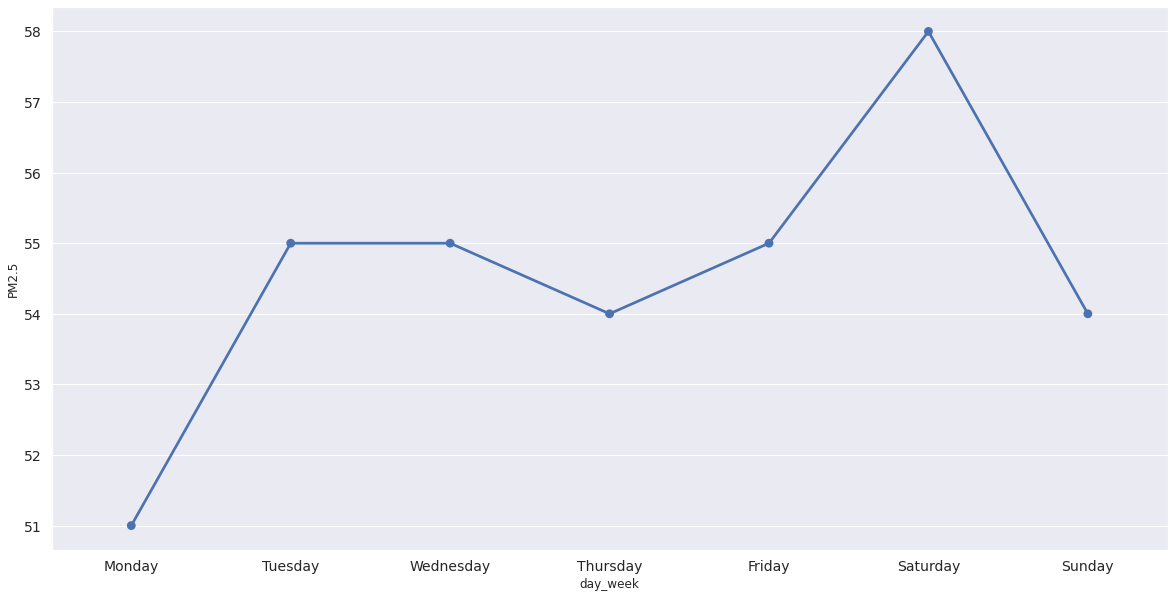

In [16]:
custom_day = {'Monday':0, 'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6}

df = new_df[['PM2.5','day_week','station']].groupby(["day_week"]).median().reset_index().sort_values(by='day_week',ascending=True)
df = df.iloc[df['day_week'].map(custom_day).argsort()]
sns.pointplot(x='day_week', y='PM2.5', data=df)

<AxesSubplot:xlabel='day_week', ylabel='PM10'>

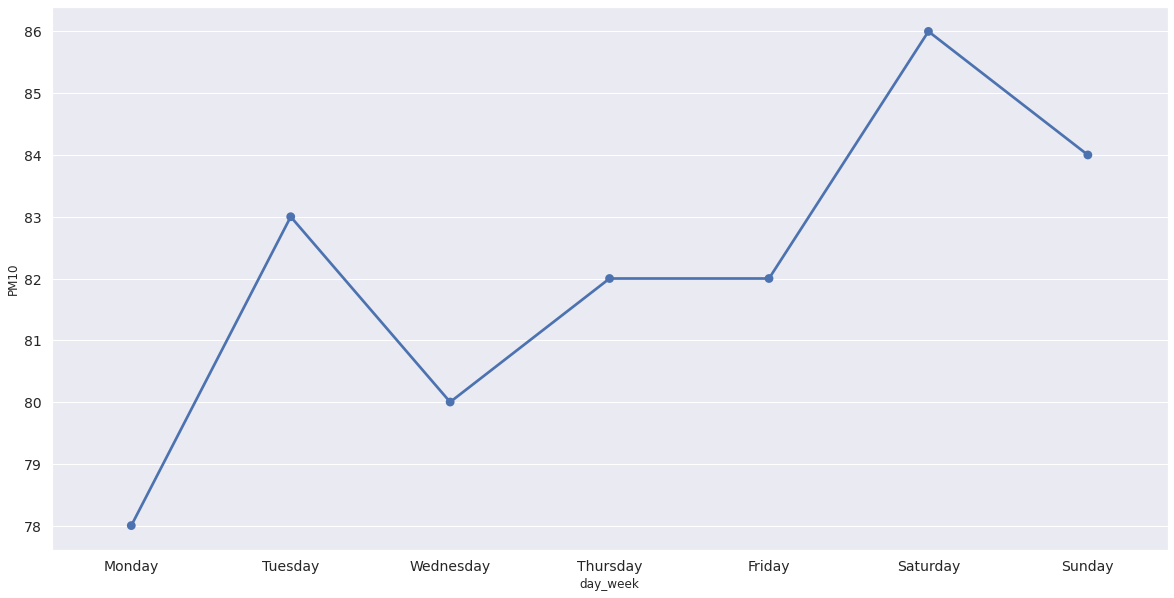

In [17]:
df = new_df[['PM10','day_week','station']].groupby(["day_week"]).median().reset_index().sort_values(by='day_week',ascending=True)
df = df.iloc[df['day_week'].map(custom_day).argsort()]
sns.pointplot(x='day_week', y='PM10', data=df)

## Analysis of Pollutants monthwise

In [18]:
monthwise_df = new_df

monthwise_df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,time,date,day_week
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,"2013,03,01,00",2013-03-01,Friday
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,"2013,03,01,01",2013-03-01,Friday
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,"2013,03,01,02",2013-03-01,Friday
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,"2013,03,01,03",2013-03-01,Friday
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,"2013,03,01,04",2013-03-01,Friday


In [19]:
monthwise_df.month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [20]:
custom_dict = {'Jan':0, 'Feb':1,'Mar':2,'Apr':3,'May':4,'Jun':5,'Jul':6,'Aug':7,'Sep':8,'Oct':9,'Nov':10,'Dec':11}

<AxesSubplot:xlabel='month', ylabel='PM2.5'>

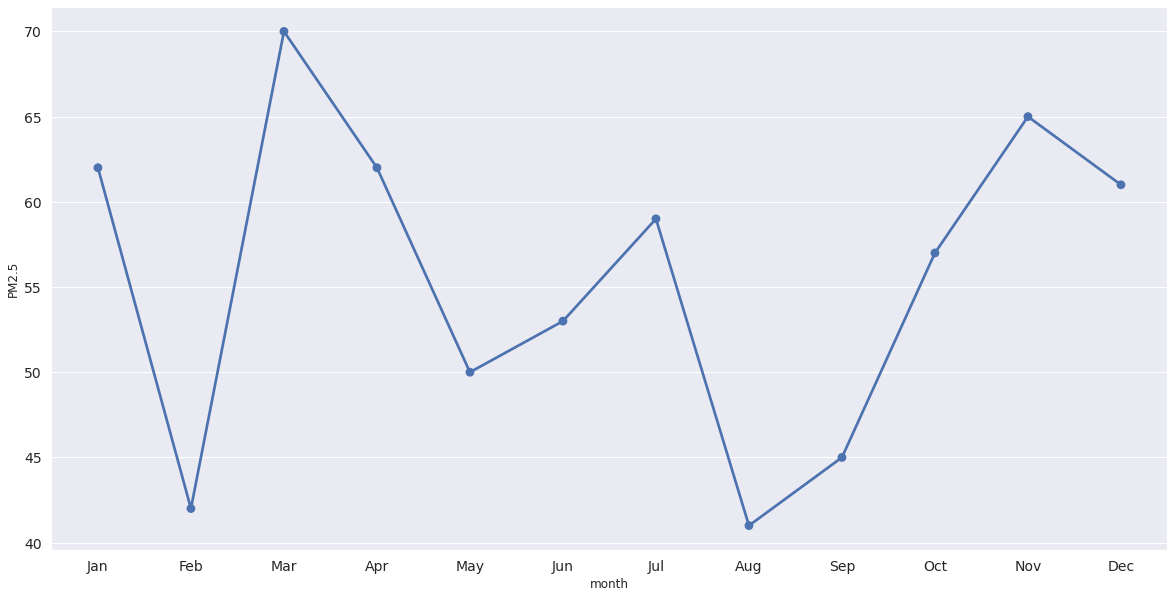

In [21]:
df = monthwise_df[['PM2.5','month','station']].groupby(["month"]).median().reset_index().sort_values(by='month',ascending=True)
df = df.iloc[df['month'].map(custom_dict).argsort()]
sns.pointplot(x='month', y='PM2.5', data=df)

<AxesSubplot:xlabel='month', ylabel='PM10'>

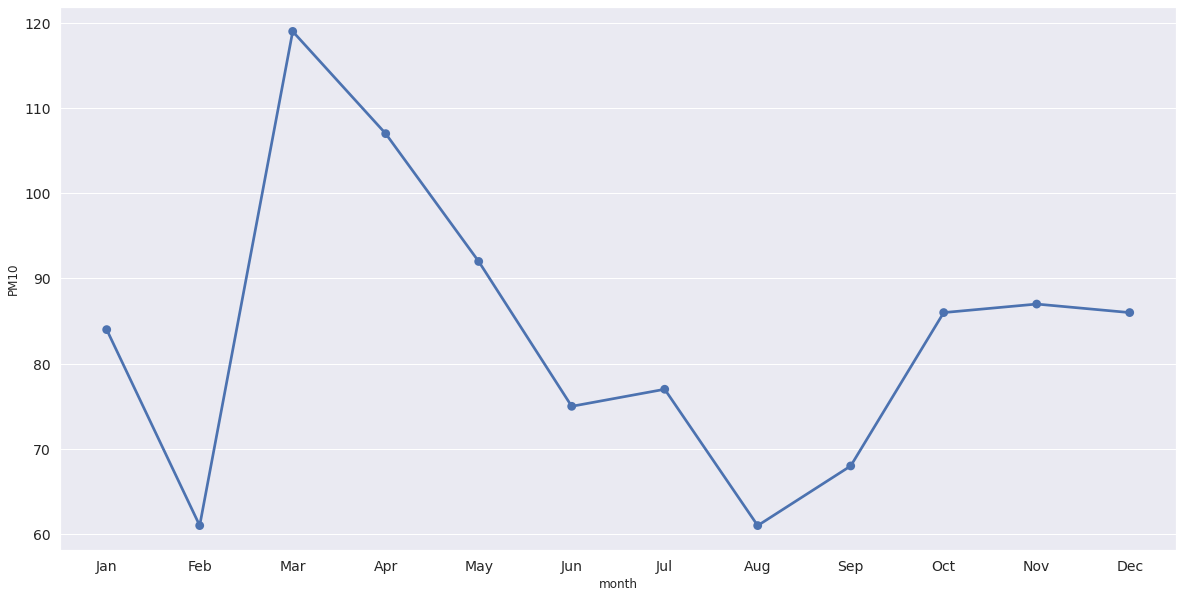

In [22]:
df = monthwise_df[['PM10','month','station']].groupby(["month"]).median().reset_index().sort_values(by='month',ascending=True)
df = df.iloc[df['month'].map(custom_dict).argsort()]
sns.pointplot(x='month', y='PM10', data=df)


## Neural Network Analysis

In [23]:

df = rnn_df.groupby(["time"]).median().reset_index().sort_values(by='time',ascending=True)
df

,time,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
0,"2013,03,01,00",1,5.5,6.5,4.0,10.0,300.0,79.0,-0.70,1023.0,-20.10,0.0
1,"2013,03,01,01",2,8.0,9.0,6.0,14.0,300.0,77.0,-1.10,1023.2,-19.30,0.0
2,"2013,03,01,02",3,4.0,5.5,5.0,12.5,300.0,74.5,-1.20,1023.5,-19.90,0.0
3,"2013,03,01,03",4,5.0,6.0,7.0,12.0,300.0,74.0,-1.40,1024.5,-19.40,0.0
4,"2013,03,01,04",5,3.0,5.0,7.0,14.0,300.0,72.0,-2.00,1025.2,-19.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
34815,"2017,02,28,19",35060,13.5,30.5,3.0,25.5,400.0,72.5,12.50,1013.5,-16.20,0.0
34816,"2017,02,28,20",35061,18.0,37.0,4.0,43.0,500.0,54.0,11.10,1013.6,-15.10,0.0
34817,"2017,02,28,21",35062,16.0,33.0,5.0,43.5,500.0,52.0,10.65,1014.2,-13.30,0.0
34818,"2017,02,28,22",35063,11.5,26.5,5.0,40.0,500.0,53.5,9.70,1014.4,-12.90,0.0


In [24]:
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.python.keras.layers import Dense, LSTM , Dropout
from tensorflow.python.keras import Sequential
from math import sqrt;
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
# frame as supervised learning
df = df.drop(columns=['time', 'No'])
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN
0,5.5,6.5,4.0,10.0,300.0,79.0,-0.70,1023.0,-20.10,0.0
1,8.0,9.0,6.0,14.0,300.0,77.0,-1.10,1023.2,-19.30,0.0
2,4.0,5.5,5.0,12.5,300.0,74.5,-1.20,1023.5,-19.90,0.0
3,5.0,6.0,7.0,12.0,300.0,74.0,-1.40,1024.5,-19.40,0.0
4,3.0,5.0,7.0,14.0,300.0,72.0,-2.00,1025.2,-19.50,0.0
...,...,...,...,...,...,...,...,...,...,...
34815,13.5,30.5,3.0,25.5,400.0,72.5,12.50,1013.5,-16.20,0.0
34816,18.0,37.0,4.0,43.0,500.0,54.0,11.10,1013.6,-15.10,0.0
34817,16.0,33.0,5.0,43.5,500.0,52.0,10.65,1014.2,-13.30,0.0
34818,11.5,26.5,5.0,40.0,500.0,53.5,9.70,1014.4,-12.90,0.0


In [26]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled

array([[0.00388802, 0.00373134, 0.01604278, ..., 0.66131907, 0.23584906,
        0.        ],
       [0.00777605, 0.00639659, 0.02673797, ..., 0.66488414, 0.24842767,
        0.        ],
       [0.00155521, 0.00266525, 0.02139037, ..., 0.67023173, 0.23899371,
        0.        ],
       ...,
       [0.02021773, 0.03198294, 0.02139037, ..., 0.50445633, 0.3427673 ,
        0.        ],
       [0.01321928, 0.0250533 , 0.02139037, ..., 0.50802139, 0.3490566 ,
        0.        ],
       [0.01710731, 0.02452026, 0.02406417, ..., 0.5026738 , 0.31996855,
        0.        ]])

In [27]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t)
1,0.003888,0.003731,0.016043,0.031553,0.022099,0.222065,0.280977,0.661319,0.235849,0.0,0.007776
2,0.007776,0.006397,0.026738,0.050971,0.022099,0.216397,0.273997,0.664884,0.248428,0.0,0.001555
3,0.001555,0.002665,0.021390,0.043689,0.022099,0.209312,0.272251,0.670232,0.238994,0.0,0.003110
4,0.003110,0.003198,0.032086,0.041262,0.022099,0.207895,0.268761,0.688057,0.246855,0.0,0.000000
5,0.000000,0.002132,0.032086,0.050971,0.022099,0.202227,0.258290,0.700535,0.245283,0.0,0.001555
...,...,...,...,...,...,...,...,...,...,...,...
34815,0.013219,0.030384,0.008021,0.072816,0.022099,0.233401,0.527051,0.483066,0.308176,0.0,0.016330
34816,0.016330,0.029318,0.010695,0.106796,0.033149,0.203644,0.511344,0.491979,0.297170,0.0,0.023328
34817,0.023328,0.036247,0.016043,0.191748,0.044199,0.151215,0.486911,0.493761,0.314465,0.0,0.020218
34818,0.020218,0.031983,0.021390,0.194175,0.044199,0.145547,0.479058,0.504456,0.342767,0.0,0.013219


## Spliting into train and test sets

In [28]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :10], train[:, 10]
test_X, test_y = test[:, :10], test[:, 10]


In [29]:
# convert input to three dimensions as required by LSTM [samples,timesteps,features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))  
print(train_X.shape[0])
print("--------------------------")
print(train_X.shape[1])
print("--------------------------")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


8760
--------------------------
1
--------------------------
(8760, 1, 10) (8760,) (26059, 1, 10) (26059,)


## Neural Network Design

In [30]:
# design network
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2]), activation = "relu"))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True, activation = "relu"))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True, activation = "relu"))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, activation = "relu"))   # next layer is output dense layer, do not need return sequence
model.add(Dropout(0.2))

model.add(Dense(1,activation='linear'))

model.compile(loss='mse', optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 100)            44400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [32]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 13s - loss: 0.0158 - val_loss: 0.0143
Epoch 2/50
122/122 - 2s - loss: 0.0072 - val_loss: 0.0047
Epoch 3/50
122/122 - 2s - loss: 0.0047 - val_loss: 0.0021
Epoch 4/50
122/122 - 2s - loss: 0.0028 - val_loss: 0.0017
Epoch 5/50
122/122 - 2s - loss: 0.0026 - val_loss: 0.0014
Epoch 6/50
122/122 - 2s - loss: 0.0024 - val_loss: 0.0012
Epoch 7/50
122/122 - 2s - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
122/122 - 2s - loss: 0.0021 - val_loss: 0.0011
Epoch 9/50
122/122 - 2s - loss: 0.0019 - val_loss: 9.7720e-04
Epoch 10/50
122/122 - 2s - loss: 0.0018 - val_loss: 9.0042e-04
Epoch 11/50
122/122 - 2s - loss: 0.0017 - val_loss: 0.0011
Epoch 12/50
122/122 - 2s - loss: 0.0017 - val_loss: 8.1059e-04
Epoch 13/50
122/122 - 2s - loss: 0.0016 - val_loss: 7.6216e-04
Epoch 14/50
122/122 - 2s - loss: 0.0015 - val_loss: 6.9321e-04
Epoch 15/50
122/122 - 2s - loss: 0.0014 - val_loss: 6.8338e-04
Epoch 16/50
122/122 - 2s - loss: 0.0014 - val_loss: 7.5119e-04
Epoch 17/50
122/122 - 2s - loss: 0.0

## Validation

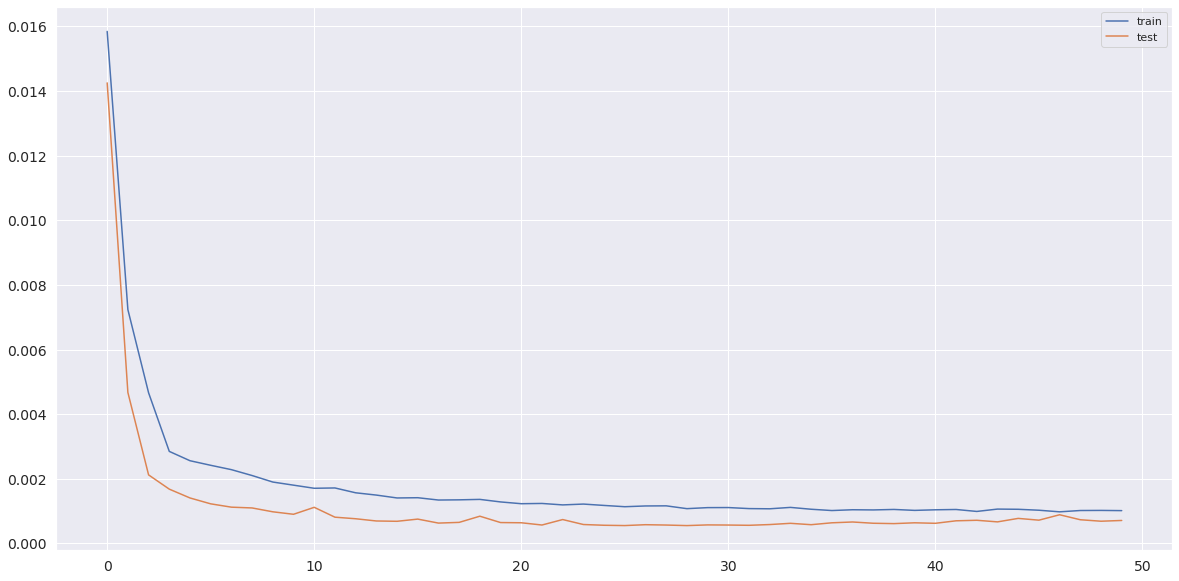

In [33]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

## RMSE and MAE for test data

In [35]:
# calculate RMSE and MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = (mean_absolute_error(inv_y, inv_yhat))
print('Test MAE: %.3f' % mae)

Test RMSE: 17.121
Test MAE: 11.702


Actual : [30.5 35.5 35.5 ... 16.  11.5 14. ]
Predicted: [19.11223733 30.68855794 40.01592858 ... 19.35219987 19.1909585
 18.43677888]


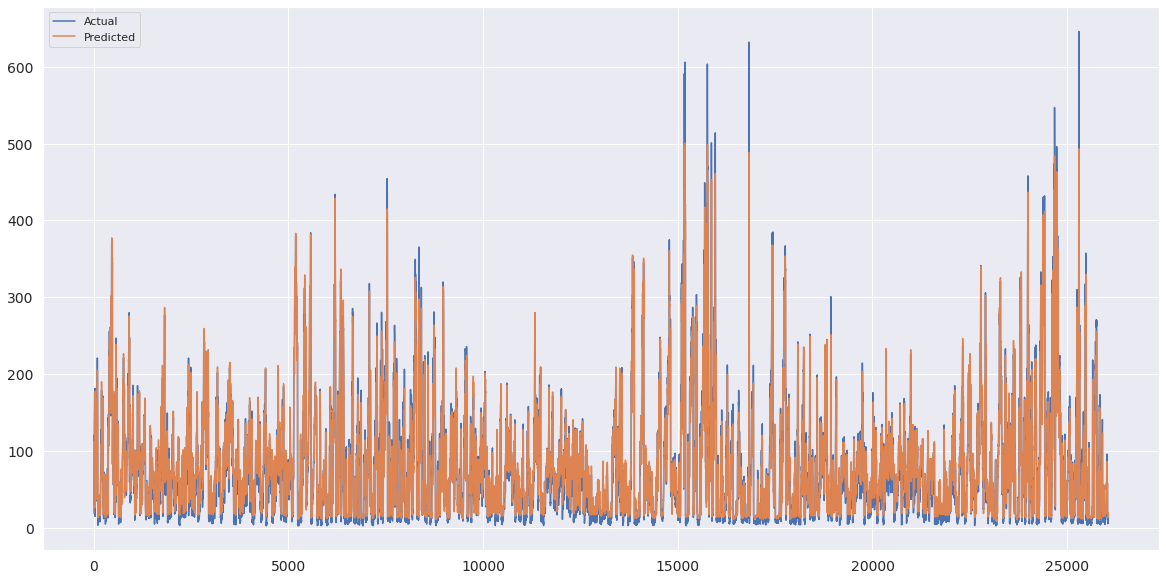

In [36]:
print('Actual :', inv_y)
print('Predicted:', inv_yhat)
# plot history
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## RMSE and MAE for train data

In [37]:
# To compare with the RMSE and MAE of the train dataset
yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [38]:
# calculate RMSE and MAE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Train RMSE: %.3f' % rmse)
mae = (mean_absolute_error(inv_y, inv_yhat))
print('Train MAE: %.3f' % mae)

Train RMSE: 18.094
Train MAE: 12.567


Actual : [ 8.   4.   5.  ... 14.5  8.5 24. ]
Predicted: [13.88970216 14.83637784 13.91517923 ... 16.9505432  16.0581608
 14.66923908]


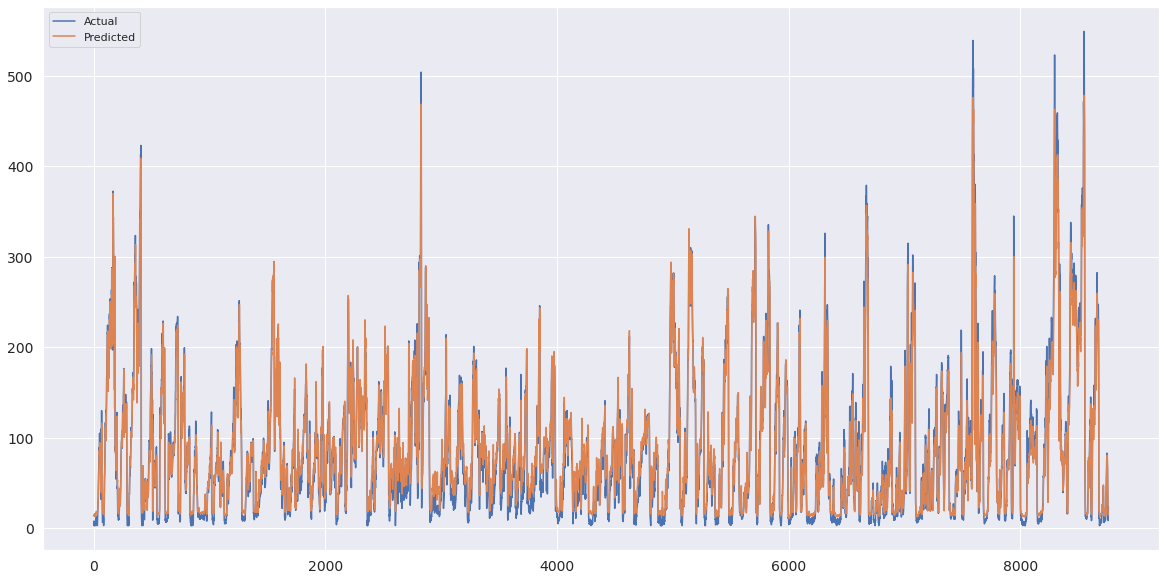

In [39]:
print('Actual :', inv_y)
print('Predicted:', inv_yhat)
# plot history
pyplot.plot(inv_y, label='Actual')
pyplot.plot(inv_yhat, label='Predicted')
pyplot.legend()
pyplot.show()